In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [89]:
# Load the data
file_path = 'C:/Users/admin/Downloads/Superstore Dataset.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,2,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
2,3,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
3,4,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
4,5,US-2019-141817,2019-01-05,2019-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


In [90]:
# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [91]:
# Specify the category you want to forecast
category = 'Furniture'

In [92]:
#Filter data for the specified category
df_category = df[df['Category'] == category]

In [93]:
# Aggregate sales by date
df_sales = df_category.groupby('Order Date')['Sales'].sum().reset_index()
df_sales = df_sales.sort_values('Order Date')
df_sales.set_index('Order Date', inplace=True)


In [94]:
# Resample data to get daily sales
df_sales = df_sales.resample('D').sum()

# Fill missing values
df_sales['Sales'] = df_sales['Sales'].fillna(0)

# Normalize the sales data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_sales['Sales'].values.reshape(-1, 1))


In [95]:
# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 10  # Define sequence length
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [96]:
# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [108]:
'''# Define the LSTM model
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')'''
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=256, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=128, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [109]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [110]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/50
18/18 [==============================] - 23s 405ms/step - loss: 7.0393 - val_loss: 5.4426
Epoch 2/50
18/18 [==============================] - 4s 195ms/step - loss: 4.8018 - val_loss: 3.9010
Epoch 3/50
18/18 [==============================] - 3s 192ms/step - loss: 3.4830 - val_loss: 2.9177
Epoch 4/50
18/18 [==============================] - 4s 200ms/step - loss: 2.6560 - val_loss: 2.2802
Epoch 5/50
18/18 [==============================] - 3s 192ms/step - loss: 2.1022 - val_loss: 1.8379
Epoch 6/50
18/18 [==============================] - 4s 197ms/step - loss: 1.7105 - val_loss: 1.5079
Epoch 7/50
18/18 [==============================] - 3s 188ms/step - loss: 1.4131 - val_loss: 1.2539
Epoch 8/50
18/18 [==============================] - 4s 214ms/step - loss: 1.1866 - val_loss: 1.0548
Epoch 9/50
18/18 [==============================] - 4s 220ms/step - loss: 1.0029 - val_loss: 0.8956
Epoch 10/50
18/18 [==============================] - 4s 208ms/step - loss: 0.8536 - val_loss: 0.765

In [111]:
# Make predictions
predicted_sales = model.predict(X_test)
predicted_sales = scaler.inverse_transform(predicted_sales)

# Compare with actual sales
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

38/38 [==============================] - 4s 29ms/step


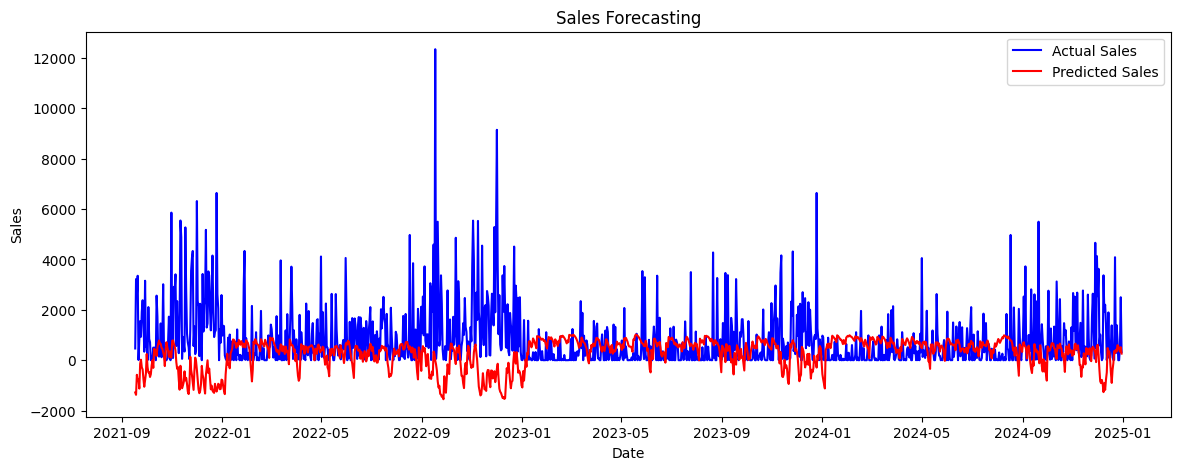

In [112]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df_sales.index[-len(actual_sales):], actual_sales, color='blue', label='Actual Sales')
plt.plot(df_sales.index[-len(predicted_sales):], predicted_sales, color='red', label='Predicted Sales')
plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate Mean Squared Error
mse = mean_squared_error(actual_sales, predicted_sales)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(actual_sales, predicted_sales)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(actual_sales, predicted_sales)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 2408853.0063795014
Mean Absolute Error (MAE): 1009.4223717525153
Mean Absolute Percentage Error (MAPE): 490.14847659768714%
